# Машинное обучение, ФКН ВШЭ

## Практическое задание 8. Метод опорных векторов и аппроксимация ядер

### Общая информация

Дата выдачи: 30.01.2025

Мягкий дедлайн: 23:59MSK 16.02.2025

Жесткий дедлайн: 23:59MSK 23.02.2025

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимальная оценка за работу (без учёта бонусов) — 10 баллов.

Сдавать задание после указанного жёсткого срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Использование генеративных языковых моделей разрешено только в случае явного указания на это. Необходимо прописать (в соответствующих пунктах, где использовались, либо в начале/конце работы):
- какая языковая модель использовалась
- какие использовались промпты и в каких частях работы
- с какими сложностями вы столкнулись при использовании генеративных моделей, с чем они помогли больше всего

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-08-random-features-Username.ipynb

Username — ваша фамилия и имя на латинице именно в таком порядке

## О задании

На занятиях мы подробно обсуждали метод опорных векторов (SVM). В базовой версии в нём нет чего-то особенного — мы всего лишь используем специальную функцию потерь, которая не требует устремлять отступы к бесконечности; ей достаточно, чтобы отступы были не меньше +1. Затем мы узнали, что SVM можно переписать в двойственном виде, который, позволяет заменить скалярные произведения объектов на ядра. Это будет соответствовать построению модели в новом пространстве более высокой размерности, координаты которого представляют собой нелинейные модификации исходных признаков.

Ядровой SVM, к сожалению, довольно затратен по памяти (нужно хранить матрицу Грама размера $d \times d$) и по времени (нужно решать задачу условной оптимизации с квадратичной функцией, а это не очень быстро). Мы обсуждали, что есть способы посчитать новые признаки $\tilde \varphi(x)$ на основе исходных так, что скалярные произведения этих новых $\langle \tilde \varphi(x), \tilde \varphi(z) \rangle$ приближают ядро $K(x, z)$.

Мы будем исследовать аппроксимации методом Random Fourier Features (RFF, также в литературе встречается название Random Kitchen Sinks) для гауссовых ядер. Будем использовать формулы, которые немного отличаются от того, что было на лекциях (мы добавим сдвиги внутрь тригонометрических функций и будем использовать только косинусы, потому что с нужным сдвигом косинус превратится в синус):
$$\tilde \varphi(x) = (
\cos (w_1^T x + b_1),
\dots,
\cos (w_n^T x + b_n)
),$$
где $w_j \sim \mathcal{N}(0, 1/\sigma^2)$, $b_j \sim U[-\pi, \pi]$.

На новых признаках $\tilde \varphi(x)$ мы будем строить любую линейную модель.

Можно считать, что это некоторая новая парадигма построения сложных моделей. Можно направленно искать сложные нелинейные закономерности в данных с помощью градиентного бустинга или нейронных сетей, а можно просто нагенерировать большое количество случайных нелинейных признаков и надеяться, что быстрая и простая модель (то есть линейная) сможет показать на них хорошее качество. В этом задании мы изучим, насколько работоспособна такая идея.

### Алгоритм

Вам потребуется реализовать следующий алгоритм:
1. Понизить размерность выборки до new_dim с помощью метода главных компонент.
2. Для полученной выборки оценить гиперпараметр $\sigma^2$ с помощью эвристики (рекомендуем считать медиану не по всем парам объектов, а по случайному подмножеству из где-то миллиона пар объектов): $$\sigma^2 = \text{median}_{i, j = 1, \dots, \ell, i \neq j} \left\{\sum_{k = 1}^{d} (x_{ik} - x_{jk})^2 \right\}$$
3. Сгенерировать n_features наборов весов $w_j$ и сдвигов $b_j$.
4. Сформировать n_features новых признаков по формулам, приведённым выше.
5. Обучить линейную модель (логистическую регрессию или SVM) на новых признаках.
6. Повторить преобразования (PCA, формирование новых признаков) к тестовой выборке и применить модель.

In [ ]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Тестировать алгоритм мы будем на данных Fashion MNIST. Ниже код для их загрузки и подготовки.

In [ ]:
# import numpy as np

# 1 Способ
import keras
from keras.datasets import fashion_mnist
(x_train_pics, y_train), (x_test_pics, y_test) = fashion_mnist.load_data()

# # 2 Способ (если первый не работает)
# # from sklearn.datasets import fetch_openml
# # def load_fashion_mnist():
# #     X, y = fetch_openml('Fashion-MNIST', version=1, return_X_y=True, as_frame=False)
# #     X = X.reshape(-1, 28, 28).astype('uint8')
# #     y = y.astype('int64')
# #     x_train, x_test = X[:60000], X[60000:]
# #     y_train, y_test = y[:60000], y[60000:]
# #     return (x_train, y_train), (x_test, y_test)
# # (x_train_pics, y_train), (x_test_pics, y_test) = load_fashion_mnist()

x_train = x_train_pics.reshape(y_train.shape[0], -1)
x_test = x_test_pics.reshape(y_test.shape[0], -1)

##__Задание 0. (0.25 баллов)__

**Вопрос:** зачем в алгоритме нужен метод главных компонент?

**Ответ:** МГК нужен для того, чтобы уменьшить размерность матрицы признаков и при этом потерять наименьшее количество информации, мы хотим найти признаки, которые бы наиболее полно объясняли бы вариацию наблюдений. Так же PCA часто используется для борьбы с мультиколлинеарностью.

##__Задание 1. (3 балла)__

Реализуйте алгоритм, описанный выше. Можете воспользоваться шаблоном класса в `homework_practice_08_rff.py` (допишите его и исправьте несостыковки в классе пайплайна) или написать свой интерфейс.

Ваша реализация должна поддерживать следующие опции:
1. Возможность задавать значения гиперпараметров new_dim (по умолчанию 50) и n_features (по умолчанию 1000).
2. Возможность включать или выключать предварительное понижение размерности с помощью метода главных компонент.
3. Возможность выбирать тип линейной модели (логистическая регрессия или SVM с линейным ядром).

Протестируйте на данных Fashion MNIST, сформированных кодом выше. Если на тесте у вас получилась доля верных ответов не ниже 0.84 с гиперпараметрами по умолчанию, то вы всё сделали правильно.

In [ ]:
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')
from time import time

In [ ]:
from typing import Callable

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC, SVC
from sklearn.preprocessing import StandardScaler


class FeatureCreatorPlaceholder(BaseEstimator, TransformerMixin):
    def __init__(self, n_features, new_dim, func: Callable = np.cos):
        self.n_features = n_features
        self.new_dim = new_dim
        self.w = None
        self.b = None
        self.func = func

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X


class RandomFeatureCreator(FeatureCreatorPlaceholder):
    def fit(self, X, y=None):
        X_sample = X[np.random.choice(X.shape[0], (10**6, 2))]
        sigma = np.sqrt(np.median(np.sum((X_sample[:, 0] - X_sample[:, 1])**2, axis = 1)))
        self.w = np.random.normal(0, 1/sigma, (X.shape[1], self.n_features))
        self.b = np.random.uniform(-np.pi, np.pi, size = self.n_features)
        return self

    def transform(self, X, y=None):
        return self.func(X@self.w+self.b)


class OrthogonalRandomFeatureCreator(RandomFeatureCreator):
    def fit(self, X, y=None):
        raise NotImplementedError


class RFFPipeline(BaseEstimator):
    """
    Пайплайн, делающий последовательно три шага:
        1. Применение PCA
        2. Применение RFF
        3. Применение классификатора
    """
    def __init__(
            self,
            n_features: int = 1000,
            new_dim: int = 50,
            use_PCA: bool = True,
            feature_creator_class=FeatureCreatorPlaceholder,
            classifier_class=LogisticRegression,
            classifier_params=None,
            func=np.cos,
    ):
        """
        :param n_features: Количество признаков, генерируемых RFF
        :param new_dim: Количество признаков, до которых сжимает PCA
        :param use_PCA: Использовать ли PCA
        :param feature_creator_class: Класс, создающий признаки, по умолчанию заглушка
        :param classifier_class: Класс классификатора
        :param classifier_params: Параметры, которыми инициализируется классификатор
        :param func: Функция, которую получает feature_creator при инициализации.
                     Если не хотите, можете не использовать этот параметр.
        """
        self.n_features = n_features
        self.func = func
        self.new_dim = new_dim
        self.use_PCA = use_PCA
        if classifier_params is None:
            classifier_params = {}
        self.classifier_class = classifier_class
        self.classifier_params = classifier_params
        self.classifier = self.classifier_class(**self.classifier_params)
        self.feature_creator_class = feature_creator_class
        self.feature_creator = self.feature_creator_class(
            n_features=self.n_features, new_dim=self.new_dim, func=func
        )
        self.pipeline = None

    def fit(self, X, y):
        pipeline_steps = []
        if self.use_PCA:
          pipeline_steps.append(('pca', PCA(n_components = self.new_dim)))
        pipeline_steps.append(('scaler', StandardScaler()))
        pipeline_steps.append(('rff', self.feature_creator))
        pipeline_steps.append(('classifier', self.classifier))
        self.pipeline = Pipeline(pipeline_steps).fit(X, y)
        return self

    def predict_proba(self, X):
        return self.pipeline.predict_proba(X)

    def predict(self, X):
        return self.pipeline.predict(X)

##__Задание 2. (2.5 балла)__

Сравните подход со случайными признаками с обучением SVM на исходных признаках. Попробуйте вариант с обычным (линейным) SVM и с ядровым SVM. Ядровой SVM может очень долго обучаться, поэтому можно делать любые разумные вещи для ускорения: брать подмножество объектов из обучающей выборки, например.

Сравните подход со случайными признаками с вариантом, в котором вы понижаете размерность с помощью PCA и обучите градиентный бустинг. Используйте одну из реализаций CatBoost/LightGBM/XGBoost.

Сделайте выводы — насколько идея со случайными признаками работает? Сравните как с точки зрения качества, так и с точки зрения скорости обучения и применения.



---


Чтобы не сойти с ума и сократить время обучения будем безжалостно резать обучающую выборку, из исходных 60к выживет только 10к, но в целом, большой просадки по метрикам мы не увидим. Все результаты в этом пункте будем складировать в специальную табличку и после сравним модели.

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
idx = np.random.randint(0, x_train.shape[0], x_train.shape[0]//6) # здесь отбираем 10к индексов

In [ ]:
results = [] # домик для результатов

def statistics_2(clf_name, options, train_time, predict_time, y_true, y_pred, metric='Accuracy'):
    stats = {
        'Модель': clf_name,
        'Опции': options,
        'Время фит': train_time,
        'Время предикт': predict_time
    }
    if metric == 'Accuracy':
        stats[metric] = accuracy_score(y_true, y_pred)
    elif metric == 'MSE':
        stats[metric] = mean_squared_error(y_true, y_pred)
    return stats

**Логистическая регрессия c CPA и RFF**


In [ ]:
pipeline = RFFPipeline(
    feature_creator_class=RandomFeatureCreator)

start_time = time()
pipeline.fit(x_train[idx], y_train[idx])
train_time = time() - start_time

start_time = time()
y_pred = pipeline.predict(x_test)
predict_time = time() - start_time

In [ ]:
stats = statistics_2('Logreg', 'RFF, PCA', train_time, predict_time, y_test, y_pred)
results.append(stats)
pd.DataFrame([stats])

,Модель,Опции,Время фит,Время предикт,Accuracy
0,Logreg,"RFF, PCA",19.787094,0.498755,0.8379


**Линейный SVM c RFF и CPA**

!!!осторожно, работает около 3 минут!!!

Если обучать на исходных данных без понижения размерности, то точное время работы неизвестно, я выключила после 20 минут. По слухам там не меньше часа(((

In [ ]:
pipeline = RFFPipeline(
    classifier_class=LinearSVC,
    feature_creator_class=RandomFeatureCreator)

start_time = time()
pipeline.fit(x_train[idx], y_train[idx])
train_time = time() - start_time

start_time = time()
y_pred = pipeline.predict(x_test)
predict_time = time() - start_time

In [ ]:
stats = statistics_2('Linear_SVC', 'RFF, PCA', train_time, predict_time, y_test, y_pred)
results.append(stats)
pd.DataFrame([stats])

,Модель,Опции,Время фит,Время предикт,Accuracy
0,Linear_SVC,"RFF, PCA",172.44191,0.510804,0.8156


Очень тяжело и долго, добавление 1000 новых признаков сильно нагружат модель.

**Линейный SVM c CPA (без RFF)**

In [ ]:
pipeline = RFFPipeline(
    classifier_class=LinearSVC)

start_time = time()
pipeline.fit(x_train[idx], y_train[idx])
train_time = time() - start_time

start_time = time()
y_pred = pipeline.predict(x_test)
predict_time = time() - start_time

In [ ]:
stats = statistics_2('Linear_SVC', 'PCA', train_time, predict_time, y_test, y_pred)
results.append(stats)
pd.DataFrame([stats])

,Модель,Опции,Время фит,Время предикт,Accuracy
0,Linear_SVC,PCA,1.339303,0.083134,0.8162


Здесь обучаемся на 50 признаках, которые остались после PCA, качество не практически идентично модели выше, видимо 1000 новых признаков особо не улучшают долю верных ответов.

**Ядерный SVM c PCA и RFF**

In [ ]:
pipeline = RFFPipeline(
    classifier_class=SVC,
    classifier_params = {'kernel': 'rbf'},
    feature_creator_class=RandomFeatureCreator)

start_time = time()
pipeline.fit(x_train[idx], y_train[idx])
train_time = time() - start_time

start_time = time()
y_pred = pipeline.predict(x_test)
predict_time = time() - start_time

In [ ]:
stats = statistics_2('Kernel_SVC', 'RFF, PCA', train_time, predict_time, y_test, y_pred)
results.append(stats)
pd.DataFrame([stats])

,Модель,Опции,Время фит,Время предикт,Accuracy
0,Kernel_SVC,"RFF, PCA",39.000778,75.685851,0.8513


**Ядерный SVM c CPA (без RFF)**

In [ ]:
pipeline = RFFPipeline(
    classifier_class=SVC,
    classifier_params = {'kernel': 'rbf'})

start_time = time()
pipeline.fit(x_train[idx], y_train[idx])
train_time = time() - start_time

start_time = time()
y_pred = pipeline.predict(x_test)
predict_time = time() - start_time

In [ ]:
stats = statistics_2('Kernel_SVC', 'PCA', train_time, predict_time, y_test, y_pred)
results.append(stats)
pd.DataFrame([stats])

,Модель,Опции,Время фит,Время предикт,Accuracy
0,Kernel_SVC,PCA,3.792071,4.937992,0.8585


Ядерный свм обучился всего за 4 секунды на 50 признаках, хорошо справился с нелинейными разделениями, которые были в данных, показал лучшее значение метрики.

**Катбуст с PCA**

In [ ]:
# !pip install catboost
# !pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.6/233.6 kB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 4.6 MB/s eta 0:00:00


Далее попробуем обучить катбуст, сначала при дефолтных настройках, а также подберем гиперпараметры оптуной. Предварительно понижаю размерность до 50 признаков, в трейне все так же 10к наблюдений.

In [ ]:
# idx = np.random.randint(0, x_train.shape[0], x_train.shape[0]//6)

!!!осторожно, работает около 2,5 минут!!!

In [ ]:
from sklearn.decomposition import PCA
from catboost import CatBoostClassifier

pca = PCA(n_components = 50)
x_train_50 = pca.fit_transform(x_train)
x_test_50 = pca.transform(x_test)

start_time = time()
model = CatBoostClassifier(verbose = 0).fit(x_train_50[idx], y_train[idx])
train_time = time() - start_time

start_time = time()
y_pred = model.predict(x_test_50)
predict_time = time() - start_time

,Модель,Опции,Время фит,Время предикт,Accuracy
0,CB дефолт параметры,PCA,178.428286,0.383272,0.8516


In [ ]:
stats = statistics_2('CB дефолт параметры', 'PCA', train_time, predict_time, y_test, y_pred)
results.append(stats)
pd.DataFrame([stats])

**Катбуст с PCA: подбираем гиперпараметры**

Подбираем гиперпараметры по валидации, размер трейна - 7к, размер валидации - 3к

In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np
x_train_val, x_val_val, y_train_val, y_val_val = train_test_split(x_train_50[idx], y_train[idx], test_size = 0.3, random_state = 42)

In [ ]:
import optuna
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score

def objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 25, 200),
        "depth": trial.suggest_int("depth", 2, 5),
        "learning_rate": trial.suggest_float("learning_rate", 0, 1),
        }
    model = CatBoostClassifier(**params)
    model.fit(x_train_val, y_train_val, verbose=False)
    y_pred = model.predict(x_val_val)
    accuracy = accuracy_score(y_val_val, y_pred)
    return accuracy

study_cb = optuna.create_study(direction = 'maximize')
study_cb.optimize(objective, n_trials=10)

[I 2025-02-16 18:18:18,714] A new study created in memory with name: no-name-ed808791-0a4e-4763-89f2-9dd62080da90
[I 2025-02-16 18:18:27,342] Trial 0 finished with value: 0.8473333333333334 and parameters: {'iterations': 115, 'depth': 5, 'learning_rate': 0.47950442291772577}. Best is trial 0 with value: 0.8473333333333334.
[I 2025-02-16 18:18:42,874] Trial 1 finished with value: 0.843 and parameters: {'iterations': 166, 'depth': 5, 'learning_rate': 0.5599006658450126}. Best is trial 0 with value: 0.8473333333333334.
[I 2025-02-16 18:18:48,613] Trial 2 finished with value: 0.828 and parameters: {'iterations': 175, 'depth': 3, 'learning_rate': 0.8625202659315926}. Best is trial 0 with value: 0.8473333333333334.
[I 2025-02-16 18:18:53,621] Trial 3 finished with value: 0.82 and parameters: {'iterations': 119, 'depth': 3, 'learning_rate': 0.7982971656033686}. Best is trial 0 with value: 0.8473333333333334.
[I 2025-02-16 18:18:58,798] Trial 4 finished with value: 0.8136666666666666 and param

In [ ]:
start_time = time()
model = CatBoostClassifier(**study_cb.best_params, verbose = 0).fit(x_train_50[idx], y_train[idx])
train_time = time() - start_time

start_time = time()
y_pred = model.predict(x_test_50)
predict_time = time() - start_time

In [ ]:
stats = statistics_2('CB подбор гиперпараметров', 'PCA', train_time, predict_time, y_test, y_pred)
results.append(stats)
pd.DataFrame([stats])

,Модель,Опции,Время фит,Время предикт,Accuracy
0,CB подбор гиперпараметров,PCA,9.408412,0.172324,0.8182


Обучился достаточно быстро, но качество среднее, есть смысл увеличить трейн выборку для лучшего подбора гиперпараметров, сейчас 7к мб маловато

In [ ]:
pd.DataFrame(results).sort_values(by = 'Accuracy')

,Модель,Опции,Время фит,Время предикт,Accuracy
1,Linear_SVC,"RFF, PCA",172.441910,0.510804,0.8156
2,Linear_SVC,PCA,1.339303,0.083134,0.8162
6,CB подбор гиперпараметров,PCA,9.408412,0.172324,0.8182
0,Logreg,"RFF, PCA",19.787094,0.498755,0.8379
3,Kernel_SVC,"RFF, PCA",39.000778,75.685851,0.8513
5,CB дефолт параметры,PCA,178.428286,0.383272,0.8516
4,Kernel_SVC,PCA,3.792071,4.937992,0.8585


Самая высокая доля верных ответов наблюдается у Kernel_SVC с PCA (0.8585), что делает этот вариант лучшим по качеству предсказаний, его время обучения и время предсказания ниже, чем у большинства моделей. Так же хорошо сработал дефолтный катбус, но время работы - 178 секунд... Явно уступает Kernel_SVC.

##__Задание 3. (2 балла)__

Проведите эксперименты:
1. Помогает ли предварительное понижение размерности с помощью PCA?
2. Как зависит итоговое качество от n_features? Выходит ли оно на плато при росте n_features?
3. Важно ли, какую модель обучать — логистическую регрессию или SVM?

**Помогает ли предварительное понижение размерности с помощью PCA?**

In [ ]:
idx = np.random.randint(0, x_train.shape[0], x_train.shape[0]//60)
idx.shape

(1000,)

In [ ]:
def statistics_3 (model, y_true, x_test):
  y_pred = model.predict(x_test)
  return {'Accuracy': accuracy_score(y_true, y_pred),
          'Presicion': precision_score(y_true, y_pred, average='macro'),
          'Recall': recall_score(y_true, y_pred, average='macro')}

In [ ]:
from tqdm import tqdm

new_dims = np.arange(10, 600, 30)
results = []
for i in tqdm(new_dims):
  pipeline = RFFPipeline(new_dim = i).fit(x_train[idx], y_train[idx])
  res_i = statistics_3(pipeline, y_test, x_test)
  res_i['Num_dim'] = i
  print(res_i)
  results.append(res_i)
res_df = pd.DataFrame(results)

  5%|▌         | 1/20 [00:00<00:08,  2.35it/s]

{'Accuracy': 0.733, 'Presicion': 0.7358480506823809, 'Recall': 0.733, 'Num_dim': 10}


 10%|█         | 2/20 [00:01<00:10,  1.70it/s]

{'Accuracy': 0.7758, 'Presicion': 0.7767202321756207, 'Recall': 0.7758, 'Num_dim': 40}


 15%|█▌        | 3/20 [00:02<00:14,  1.14it/s]

{'Accuracy': 0.7546, 'Presicion': 0.7577843552838743, 'Recall': 0.7546, 'Num_dim': 70}


 20%|██        | 4/20 [00:03<00:16,  1.05s/it]

{'Accuracy': 0.7474, 'Presicion': 0.7530786971544681, 'Recall': 0.7474000000000001, 'Num_dim': 100}


 25%|██▌       | 5/20 [00:04<00:16,  1.11s/it]

{'Accuracy': 0.7354, 'Presicion': 0.7418949287069965, 'Recall': 0.7354, 'Num_dim': 130}


 30%|███       | 6/20 [00:05<00:13,  1.01it/s]

{'Accuracy': 0.7299, 'Presicion': 0.7380737171384593, 'Recall': 0.7299, 'Num_dim': 160}


 35%|███▌      | 7/20 [00:06<00:12,  1.06it/s]

{'Accuracy': 0.7249, 'Presicion': 0.7327125301156173, 'Recall': 0.7249000000000001, 'Num_dim': 190}


 40%|████      | 8/20 [00:07<00:11,  1.06it/s]

{'Accuracy': 0.7228, 'Presicion': 0.7312935006842542, 'Recall': 0.7228000000000001, 'Num_dim': 220}


 45%|████▌     | 9/20 [00:08<00:10,  1.03it/s]

{'Accuracy': 0.7181, 'Presicion': 0.7268690802813583, 'Recall': 0.7181, 'Num_dim': 250}


 50%|█████     | 10/20 [00:09<00:10,  1.08s/it]

{'Accuracy': 0.713, 'Presicion': 0.7239123307866494, 'Recall': 0.7130000000000001, 'Num_dim': 280}


 55%|█████▌    | 11/20 [00:12<00:13,  1.54s/it]

{'Accuracy': 0.7064, 'Presicion': 0.7182123129649177, 'Recall': 0.7064, 'Num_dim': 310}


 60%|██████    | 12/20 [00:13<00:11,  1.49s/it]

{'Accuracy': 0.7032, 'Presicion': 0.7156152790139735, 'Recall': 0.7032, 'Num_dim': 340}


 65%|██████▌   | 13/20 [00:15<00:10,  1.45s/it]

{'Accuracy': 0.6959, 'Presicion': 0.710124589377921, 'Recall': 0.6959, 'Num_dim': 370}


 70%|███████   | 14/20 [00:16<00:08,  1.49s/it]

{'Accuracy': 0.6856, 'Presicion': 0.6994154570767585, 'Recall': 0.6856000000000001, 'Num_dim': 400}


 75%|███████▌  | 15/20 [00:18<00:07,  1.49s/it]

{'Accuracy': 0.6819, 'Presicion': 0.6955100020992111, 'Recall': 0.6819, 'Num_dim': 430}


 80%|████████  | 16/20 [00:19<00:06,  1.57s/it]

{'Accuracy': 0.6727, 'Presicion': 0.6885669735563981, 'Recall': 0.6727000000000001, 'Num_dim': 460}


 85%|████████▌ | 17/20 [00:21<00:04,  1.66s/it]

{'Accuracy': 0.6663, 'Presicion': 0.6839581315998882, 'Recall': 0.6663, 'Num_dim': 490}


 90%|█████████ | 18/20 [00:24<00:03,  1.90s/it]

{'Accuracy': 0.6521, 'Presicion': 0.6715327475421484, 'Recall': 0.6521000000000001, 'Num_dim': 520}


 95%|█████████▌| 19/20 [00:26<00:02,  2.13s/it]

{'Accuracy': 0.6363, 'Presicion': 0.6576937604632547, 'Recall': 0.6363000000000001, 'Num_dim': 550}


100%|██████████| 20/20 [00:29<00:00,  1.46s/it]

{'Accuracy': 0.6267, 'Presicion': 0.6502537135530245, 'Recall': 0.6266999999999999, 'Num_dim': 580}


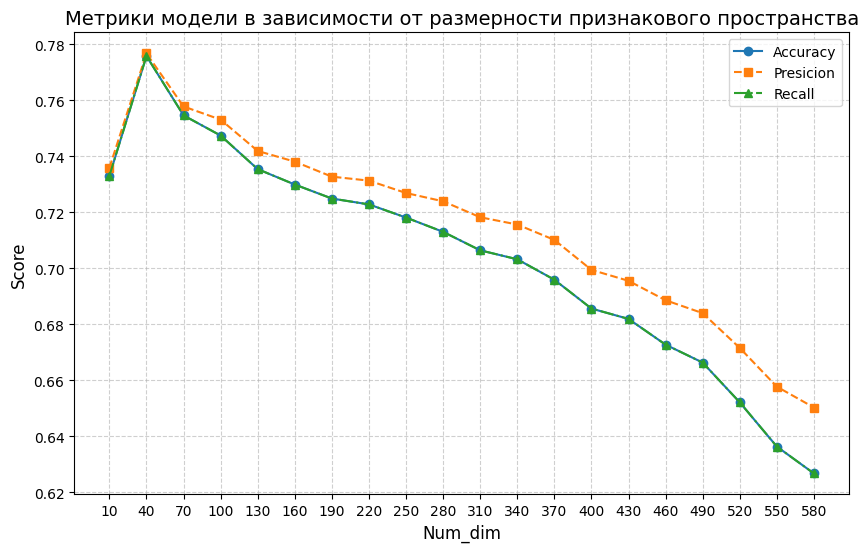

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(res_df["Num_dim"], res_df["Accuracy"], marker="o", label="Accuracy", linestyle='-')
plt.plot(res_df["Num_dim"], res_df["Presicion"], marker="s", label="Presicion", linestyle='--')
plt.plot(res_df["Num_dim"], res_df["Recall"], marker="^", label="Recall", linestyle='-.')

plt.xlabel("Num_dim", fontsize=12)
plt.ylabel("Score", fontsize=12)
plt.title("Метрики модели в зависимости от размерности признакового пространства", fontsize=14)
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.xticks(res_df["Num_dim"]);

Оптимальное количество признаков при PCA – около 30-50, где метрики достигают максимума (~0.78). Дальнейшее увеличение добавляет шум и снижает качество модели.

**Как зависит итоговое качество от n_features? Выходит ли оно на плато при росте n_features?**

In [ ]:
from tqdm import tqdm

n_features = np.arange(100, 3000, 200)
results = []
for i in tqdm(n_features):
  pipeline = RFFPipeline(n_features = i, feature_creator_class=RandomFeatureCreator).fit(x_train[idx], y_train[idx])
  res_i = statistics_3(pipeline, y_test, x_test)
  res_i['N_features'] = i
  print(res_i)
  results.append(res_i)
res_df = pd.DataFrame(results)

  7%|▋         | 1/15 [00:01<00:26,  1.91s/it]

{'Accuracy': 0.7438, 'Presicion': 0.744064745347509, 'Recall': 0.7438, 'N_features': 100}


 13%|█▎        | 2/15 [00:05<00:38,  2.97s/it]

{'Accuracy': 0.7704, 'Presicion': 0.775227615901137, 'Recall': 0.7704, 'N_features': 300}


 20%|██        | 3/15 [00:07<00:28,  2.39s/it]

{'Accuracy': 0.7835, 'Presicion': 0.7868605783282325, 'Recall': 0.7834999999999999, 'N_features': 500}


 27%|██▋       | 4/15 [00:09<00:24,  2.21s/it]

{'Accuracy': 0.7817, 'Presicion': 0.7848173651085946, 'Recall': 0.7817000000000001, 'N_features': 700}


 33%|███▎      | 5/15 [00:11<00:22,  2.22s/it]

{'Accuracy': 0.7807, 'Presicion': 0.7841934649547835, 'Recall': 0.7807000000000001, 'N_features': 900}


 40%|████      | 6/15 [00:14<00:23,  2.57s/it]

{'Accuracy': 0.7855, 'Presicion': 0.7871879607045279, 'Recall': 0.7855000000000001, 'N_features': 1100}


 47%|████▋     | 7/15 [00:20<00:28,  3.57s/it]

{'Accuracy': 0.7834, 'Presicion': 0.7869555716033323, 'Recall': 0.7834, 'N_features': 1300}


 53%|█████▎    | 8/15 [00:24<00:25,  3.70s/it]

{'Accuracy': 0.7846, 'Presicion': 0.7878571110908923, 'Recall': 0.7846, 'N_features': 1500}


 60%|██████    | 9/15 [00:29<00:24,  4.07s/it]

{'Accuracy': 0.79, 'Presicion': 0.7933119357161269, 'Recall': 0.7899999999999999, 'N_features': 1700}


 67%|██████▋   | 10/15 [00:34<00:22,  4.58s/it]

{'Accuracy': 0.784, 'Presicion': 0.7874702323772835, 'Recall': 0.784, 'N_features': 1900}


 73%|███████▎  | 11/15 [00:40<00:19,  4.92s/it]

{'Accuracy': 0.7875, 'Presicion': 0.7908366637451162, 'Recall': 0.7875, 'N_features': 2100}


 80%|████████  | 12/15 [00:47<00:16,  5.58s/it]

{'Accuracy': 0.7843, 'Presicion': 0.788398050016059, 'Recall': 0.7843, 'N_features': 2300}


 87%|████████▋ | 13/15 [00:53<00:11,  5.63s/it]

{'Accuracy': 0.7874, 'Presicion': 0.789446522063561, 'Recall': 0.7873999999999999, 'N_features': 2500}


 93%|█████████▎| 14/15 [01:01<00:06,  6.38s/it]

{'Accuracy': 0.7856, 'Presicion': 0.788921139743139, 'Recall': 0.7856, 'N_features': 2700}


100%|██████████| 15/15 [01:07<00:00,  4.52s/it]

{'Accuracy': 0.7859, 'Presicion': 0.7884228208592889, 'Recall': 0.7859, 'N_features': 2900}


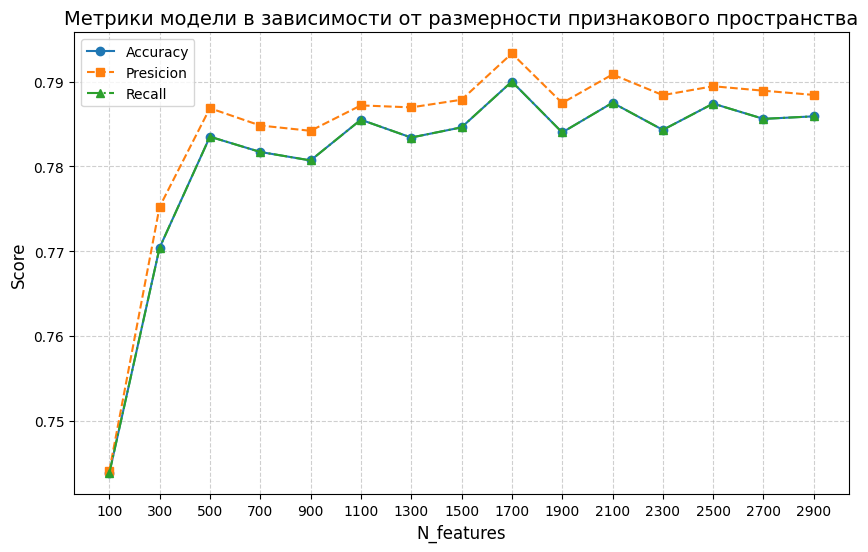

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(res_df["N_features"], res_df["Accuracy"], marker="o", label="Accuracy", linestyle='-')
plt.plot(res_df["N_features"], res_df["Presicion"], marker="s", label="Presicion", linestyle='--')
plt.plot(res_df["N_features"], res_df["Recall"], marker="^", label="Recall", linestyle='-.')

plt.xlabel("N_features", fontsize=12)
plt.ylabel("Score", fontsize=12)
plt.title("Метрики модели в зависимости от размерности признакового пространства", fontsize=14)
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.xticks(res_df["N_features"]);

Оптимальное количество новых признаков – от 500 до 1500 где-то.
Дальнейшее увеличение количества не даёт значительного прироста точности, модель достигает предела своих возможностей и дальнейшее увеличение признакового пространства избыточно, на плато вышли да.

**Важно ли, какую модель обучать — логистическую регрессию или SVM?**

In [ ]:
def run_experiment(classifier_class, classifier_params=None, N_batch = [500, 1000, 2500, 5000, 10000]):
    results = []
    for i in tqdm(N_batch):
        idx = np.random.randint(0, x_train.shape[0], i)

        pipeline = RFFPipeline(
            classifier_class=classifier_class,
            classifier_params=classifier_params,
            feature_creator_class=RandomFeatureCreator
        )

        start_time = time()
        pipeline.fit(x_train[idx], y_train[idx])
        train_time = time() - start_time

        start_time = time()
        y_pred = pipeline.predict(x_test)
        predict_time = time() - start_time

        res_i = statistics_2(f'{classifier_class.__name__}', 'RFF, PCA', train_time, predict_time, y_test, y_pred)
        res_i['N_batch'] = i
        results.append(res_i)
    return results

In [ ]:
kek = run_experiment(LogisticRegression)

100%|██████████| 5/5 [00:41<00:00,  8.24s/it]


In [ ]:
lol = run_experiment(SVC, {"kernel": "rbf"})

100%|██████████| 5/5 [03:02<00:00, 36.45s/it]


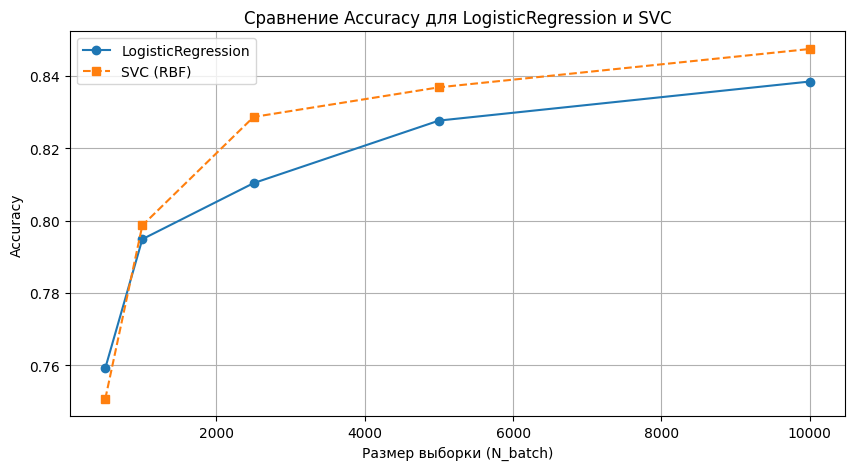

In [ ]:
df_logistic = pd.DataFrame(kek)
df_svc = pd.DataFrame(lol)

plt.figure(figsize=(10, 5))
plt.plot(df_logistic["N_batch"], df_logistic["Accuracy"], marker='o', linestyle='-', label="LogisticRegression")
plt.plot(df_svc["N_batch"], df_svc["Accuracy"], marker='s', linestyle='--', label="SVC (RBF)")
plt.xlabel("Размер выборки (N_batch)")
plt.ylabel("Accuracy")
plt.title("Сравнение Accuracy для LogisticRegression и SVC")
plt.legend()
plt.grid(True)

SVC показывает лучшую точность, но требует значительно больше времени на обучение при увеличении размера выборки.

Логрег менее точен, но масштабируется лучше и требует меньших вычислительных ресурсов.

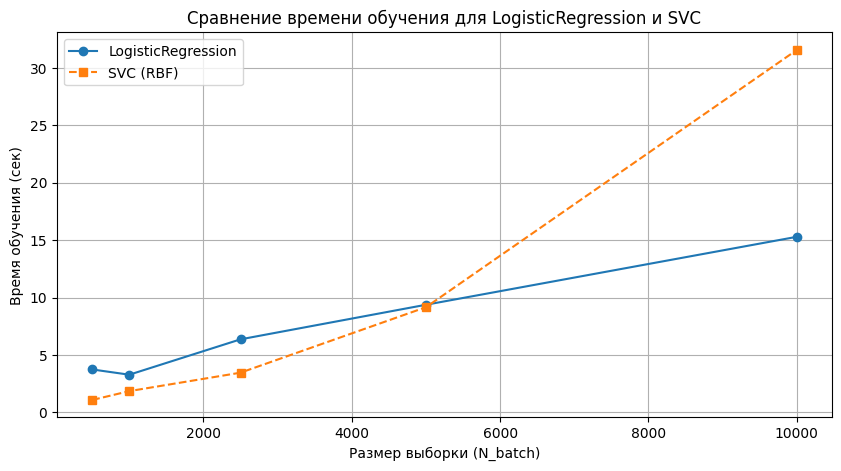

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(df_logistic["N_batch"], df_logistic["Время фит"], marker='o', linestyle='-', label="LogisticRegression")
plt.plot(df_svc["N_batch"], df_svc["Время фит"], marker='s', linestyle='--', label="SVC (RBF)")
plt.xlabel("Размер выборки (N_batch)")
plt.ylabel("Время обучения (сек)")
plt.title("Сравнение времени обучения для LogisticRegression и SVC")
plt.legend()
plt.grid(True)

##__Задание 4. (Максимум 1.5 балла)__

Как вы, должно быть, помните с курса МО-1, многие алгоритмы машинного обучения работают лучше, если признаки данных некоррелированы. Оказывается, что для RFF существует модификация, позволяющая получать ортогональные случайные признаки (Orthogonal Random Features, ORF). Об этом методе можно прочитать в [статье](https://proceedings.neurips.cc/paper/2016/file/53adaf494dc89ef7196d73636eb2451b-Paper.pdf). Реализуйте класс для вычисления ORF по аналогии с основным заданием. Обратите внимание, что ваш класс должен уметь работать со случаем n_features > new_dim (в статье есть замечание на этот счет), n_features=new_dim и n_features < new_dim также должны работать, убедитесь в этом. Проведите эксперименты, сравнивающие RFF и ORF, сделайте выводы.


In [ ]:
# new_dim = 50, n_features = 50 - все ок перемножается

# new_dim = 50
# n_features = 100
# G = np.random.randn(new_dim, n_features)
# print(f'G.shape = {G.shape}')
# Q, _ = np.linalg.qr(G)
# print(f'Q.shape = {Q.shape}')
# S = np.diag(chi.rvs(df=new_dim, size = n_features))
# print(f'S.shape = {S.shape}')

In [ ]:
idx = np.random.randint(0, x_train.shape[0], x_train.shape[0]//6)

In [ ]:
from scipy.stats import chi
from scipy.linalg import qr

class OrthogonalRandomFeatureCreator(RandomFeatureCreator):
    def fit(self, X, y=None):
        d = X.shape[1]
        D = self.n_features
        X_sample = X[np.random.choice(X.shape[0], (10**6, 2))]

        sigma = np.sqrt(np.median(np.sum((X_sample[:, 0] - X_sample[:, 1])**2, axis = 1)))

        iters = np.ceil(D/d)
        W_list=[]
        for i in range(int(iters)):
          G = np.random.randn(d, d)
          Q, _ = qr(G)
          S = np.diag(chi.rvs(df=d, size=d))
          W = (1 / sigma) * (Q @ S)
          W_list.append(W)
        W_final = np.vstack(W_list)[:D, :]
        self.w = W_final.T
        self.b = np.random.uniform(-np.pi, np.pi, size=self.n_features)
        return self

**ORF для разных D (n_features) и d (new_dim)**

In [ ]:
configs = [
    (100, 100, "d = D"),
    (50, 100, "d < D"),
    (100, 50, "d > D"),
]

for new_dim, n_features, desc in configs:
    pipeline = RFFPipeline(new_dim=new_dim, n_features=n_features, feature_creator_class=OrthogonalRandomFeatureCreator)

    start_time = time()
    pipeline.fit(x_train[idx], y_train[idx])
    train_time = time() - start_time

    start_time = time()
    y_pred = pipeline.predict(x_test)
    predict_time = time() - start_time

    acc = accuracy_score(y_test, y_pred)

    print(f'[{desc}] Время фит: {train_time:.4f} сек, Время предикт: {predict_time:.4f} сек, Accuracy: {acc:.4f}')

[d = D] Время фит: 3.1816 сек, Время предикт: 0.1592 сек, Accuracy: 0.7480
[d < D] Время фит: 5.5204 сек, Время предикт: 0.4360 сек, Accuracy: 0.8064
[d > D] Время фит: 9.1719 сек, Время предикт: 0.2877 сек, Accuracy: 0.5858


**RRF для разных D (n_features) и d (new_dim)**

In [ ]:
configs = [
    (100, 100, "d = D"),
    (50, 100, "d < D"),
    (100, 50, "d > D"),
]

for new_dim, n_features, desc in configs:
    pipeline = RFFPipeline(new_dim=new_dim, n_features=n_features, feature_creator_class=RandomFeatureCreator)

    start_time = time()
    pipeline.fit(x_train[idx], y_train[idx])
    train_time = time() - start_time

    start_time = time()
    y_pred = pipeline.predict(x_test)
    predict_time = time() - start_time

    acc = accuracy_score(y_test, y_pred)

    print(f'[{desc}] Время фит: {train_time:.4f} сек, Время предикт: {predict_time:.4f} сек, Accuracy: {acc:.4f}')

[d = D] Время фит: 3.0875 сек, Время предикт: 0.1568 сек, Accuracy: 0.7070
[d < D] Время фит: 5.0363 сек, Время предикт: 0.1963 сек, Accuracy: 0.7935
[d > D] Время фит: 3.9882 сек, Время предикт: 0.1250 сек, Accuracy: 0.5726


##__Задание 5. (Максимум 1 балл)__

Существует большое количество работ, где идея RFF развивается, предлагаются её обобщения (которые, по сути, выливаются в другие преобразования признаков, не обязательно уже тригонометрические). Возьмите любую из таких работ, кратко опишите идею, имплементируйте её и сравните качество с ORF и RFF, которые вы запрограммировали выше.

Ссылки на статьи, где обсуждаются вариации RFF для разных ядер, можно найти в окрестности таблицы 1 в работе https://arxiv.org/pdf/1407.5599  

___ссылка на работу:___

___описание идеи:___

In [ ]:
# Пример

##__Задание 6. (Максимум 2.5 балла)__

Реализуйте класс ядровой Ridge регрессии (Лекция 13, $\S 1.2$), для оптимизации используте градиентный спуск **[1 балл максимум]**, также добавьте возможность использовать аналитическую формулу **[1 балл максимум]**. Для градиентного спуска выпишите градиент ниже **[0.5 баллов максимум]**.
Подумайте о том, как в формулах правильно учесть свободный коэффициент.

Затем адаптируйте вашу реализацию RFF под задачу регрессии. Сравните вашу ядровую регрессию и RFF на синтетических данных.

Функция потерь:
$$
Q(w) = \frac{1}{2} ||\Phi \Phi^T w - y||^2 + \frac{\lambda}{2} w^T \Phi \Phi^T w \rightarrow \min_w,
$$
где $\Phi \Phi^T = K$, $K = (k(x_i, x_j))_{i, j = 1}^{\ell}$.

Предсказание:
$
y(x) = k(x)^T w,
$
где $k(x)$ — вектор функций ядра от пар объектов $(x, x_i)_{i=1}^{\ell}$.

___Выведите градиент:___
$$
\nabla ...
$$

Вы можете изменять представленный шаблон в файле `homework_practice_08_kernel_regression.py` по своему усмотрению.

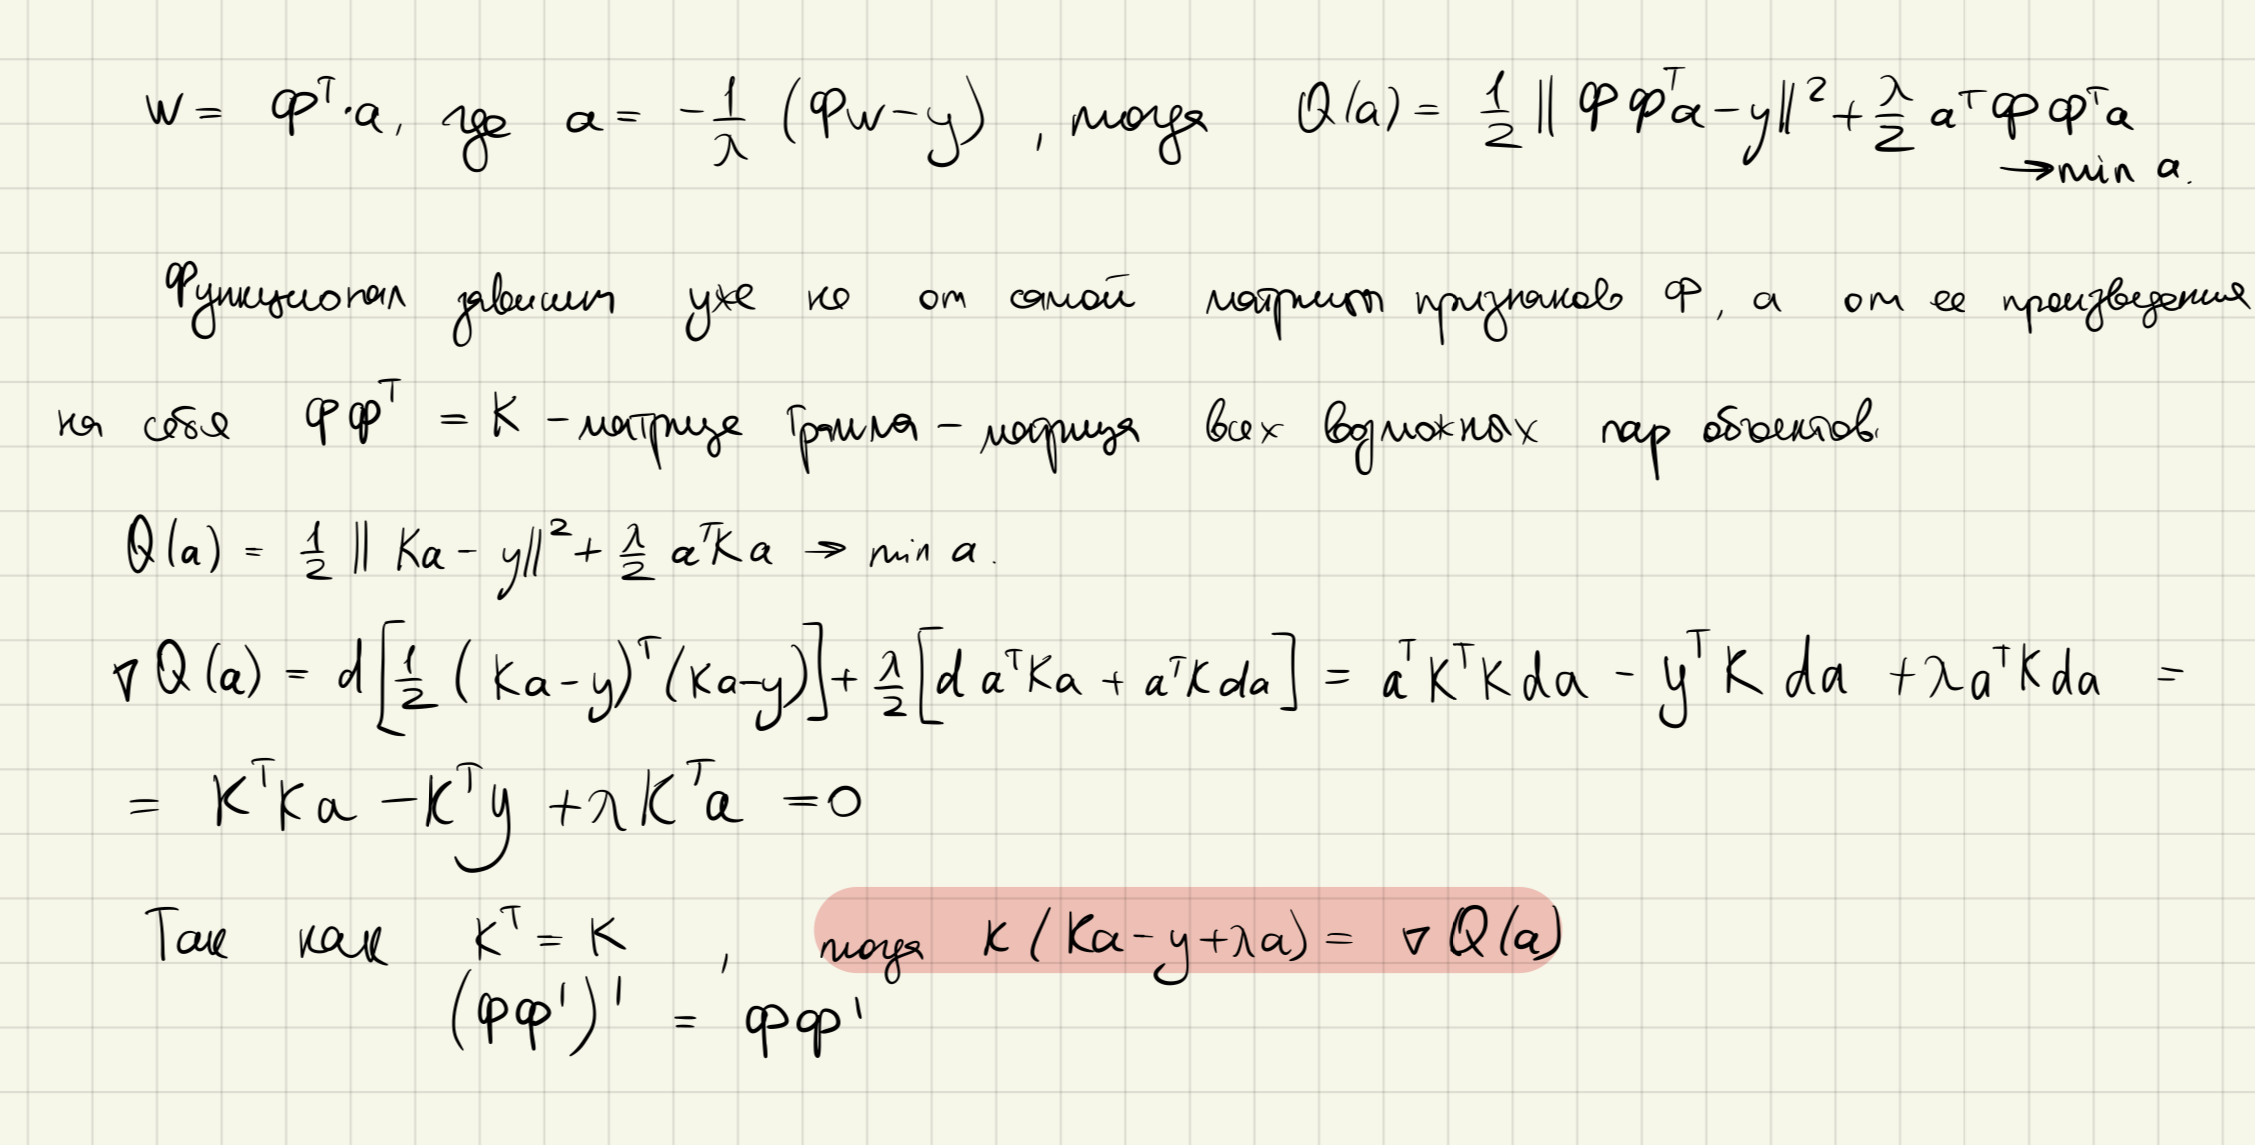

In [ ]:
import numpy as np
from sklearn.base import RegressorMixin
from sklearn.gaussian_process.kernels import RBF
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


class KernelRidgeRegression(RegressorMixin):
    """
    Kernel Ridge regression class
    """

    def __init__(
        self,
        lr=0.01,
        regularization=1.0,
        tolerance=1e-2,
        max_iter=1000,
        batch_size=64,
        kernel_scale=1.0,
        method = 'gd'
    ):
        """
        :param lr: learning rate
        :param regularization: regularization coefficient
        :param tolerance: stopping criterion for square of euclidean norm of weight difference
        :param max_iter: stopping criterion for iterations
        :param batch_size: size of the batches used in gradient descent steps
        :parame kernel_scale: length scale in RBF kernel formula
        """

        self.lr: float = lr
        self.regularization: float = regularization
        self.w: np.ndarray | None = None

        self.tolerance: float = tolerance
        self.max_iter: int = max_iter
        self.batch_size: int = batch_size
        self.loss_history: list[float] = []
        self.kernel = RBF(kernel_scale)
        self.method = method

    def calc_loss(self, x: np.ndarray, y: np.ndarray) -> float:
        """
        Calculating loss for x and y dataset
        :param x: features array
        :param y: targets array
        """
        self.K = self.kernel(x)
        loss = 0.5*np.linalg.norm(self.K@self.w-y)**2 + 0.5*self.regularization * self.w.T @ self.K @ self.w
        return loss

    def calc_grad(self, x: np.ndarray, y: np.ndarray) -> float:
        """
        Calculating gradient for x and y dataset
        :param x: features array
        :param y: targets array
        """
        batch_ind = np.random.choice(x.shape[0], self.batch_size)
        K_batch = self.K[batch_ind, :]
        grad = K_batch.T @ (K_batch @ self.w - y[batch_ind]) + self.regularization* self.K @ self.w
        return grad

    def fit(self, x: np.ndarray, y: np.ndarray) -> "KernelRidgeRegression":
        """
        Получение параметров с помощью градиентного спуска
        :param x: features array
        :param y: targets array
        :return: self
        """
        self.x_train = x
        self.w = np.random.uniform(-1, 1, x.shape[0])
        self.loss_history.append(self.calc_loss(x,y))

        if self.method == 'analytic':
          self.w = self.fit_closed_form(x, y)
        else:
          for i in range(self.max_iter):
            step = self.lr*self.calc_grad(x,y)
            self.w -= step
            self.loss_history.append(self.calc_loss(x,y))
            if np.linalg.norm(-step)**2 <= self.tolerance:
              break
        return self

    def fit_closed_form(self, x: np.ndarray, y: np.ndarray) -> "KernelRidgeRegression":
        """
        Получение параметров через аналитическое решение
        :param x: features array
        :param y: targets array
        :return: self
        """
        n_samples = x.shape[0]
        w_closed_form = np.linalg.solve(self.K + self.regularization * np.eye(n_samples), y)
        return w_closed_form

    def predict(self, x):
        """Predicts values for given input."""
        K_test = self.kernel(x, self.x_train)
        y_pred = K_test @ self.w
        return y_pred

In [ ]:
# выборка 1
n_samples = 3000
n_features = 50

x = np.random.rand(n_samples, n_features)
y_true = np.sin(2 * x[:, 0]) + 0.5 * np.cos(x[:, 1]) - 0.3 * x[:, 2]**2
noise = np.random.normal(scale=0.1, size=y_true.shape)
y = y_true + noise

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [ ]:
# # выборка 2
# x = np.random.rand(3000, 50)
# y_true = np.random.rand(3000)
# x_train, x_test, y_train, y_test = train_test_split(x, y_true, test_size=0.2, random_state=42)

In [ ]:
gd_vs_analytic = []
preds = []
for method in (['gd', 'analytic']):
  start_time = time()
  model = KernelRidgeRegression(method=method).fit(x_train, y_train)
  train_time = time() - start_time

  start_time = time()
  y_pred = model.predict(x_test)
  preds.append(y_pred)
  predict_time = time() - start_time

  stats = statistics_2("KRR", method, train_time, predict_time, y_test, y_pred, 'MSE')
  gd_vs_analytic.append(stats)
pd.DataFrame(gd_vs_analytic)

,Модель,Опции,Время фит,Время предикт,MSE
0,KRR,gd,40.070348,0.083999,0.347249
1,KRR,analytic,0.909432,0.096378,0.074121


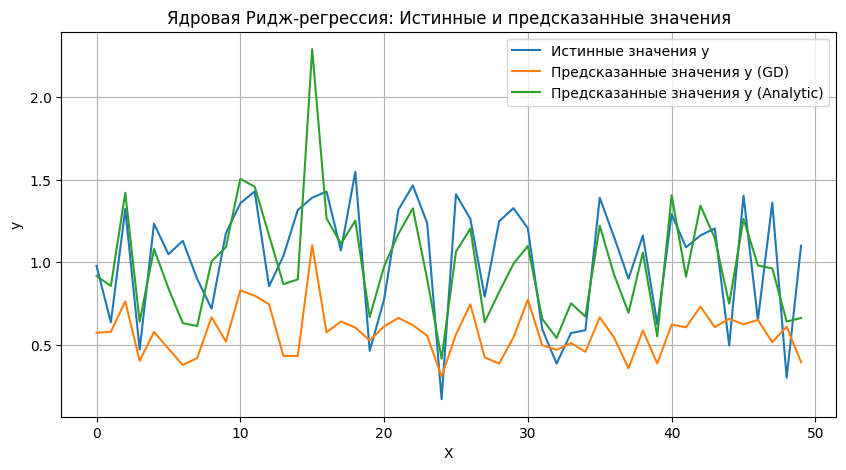

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(y_test[50:100], label="Истинные значения y")
plt.plot(preds[0][50:100], label="Предсказанные значения y (GD)")
plt.plot(preds[1][50:100], label="Предсказанные значения y (Analytic)")
plt.grid(True)
plt.legend()
plt.xlabel("X")
plt.ylabel("y")
plt.title("Ядровая Ридж-регрессия: Истинные и предсказанные значения");

Оранжевая линия (GD) значительно занижена и отличается от истинных значений, динамика ок, но почему-то сильное смещение.

Зелёная линия (Analytic) ближе к истинным значениям и лучше отражает колебания данных.

Аналитический метод даёт более точные предсказания, чем метод градиентного спуска, да и работает быстрее, хотя это наверное только при малом количестве данных, дальше матрицы слишком большие и гд уже по батчам будет лучше считать.